# Project 1: Linear Models
**Course:** CAP 4105 - Introduction to Machine Learning  
**Author:** Isabella Correa ID: 6043518  
---
## Notebook Structure
0. Imports and Setup  
1. Data Exploration & Preprocessing  
2. Linear Regression (NumPy, PyTorch, Polynomial)  
3. Logistic Regression (NumPy, PyTorch, Analysis)  
4. Summary & Reflection

---
## 0. Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from pathlib import Path

# Plot style
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

# Data path
DATA_DIRECTORY = Path("dataset")
training_raw = pd.read_csv(DATA_DIRECTORY / "train.csv")
testing_raw = pd.read_csv(DATA_DIRECTORY / "test.csv")
print("Training shape:", training_raw.shape, "\nTesting shape:", testing_raw.shape)
print("\nThis describes the shape of the training and test datasets. \nThe training dataset has 326 rows and 8 columns, the test dataset has 80 rows and 8 columns.")

Training shape: (326, 8) 
Testing shape: (80, 8)

This describes the shape of the training and test datasets. 
The training dataset has 326 rows and 8 columns, the test dataset has 80 rows and 8 columns.


---
# 1. Data Exploration & Preprocessing

## 1.1 Exploratory Data Analysis


In [2]:
# Shapes, dtypes, and statistics
feature_columns = ["hours_studied", "sleep_hours", "attendance_rate", "prev_exam_score"]
print("Shape:", training_raw.shape)
print("\nDtypes:\n", training_raw.dtypes)
print("\nInfo:")
training_raw.info()
print("\nDescribe:")
training_raw.describe(include="all")

Shape: (326, 8)

Dtypes:
 student_id           int64
hours_studied      float64
sleep_hours        float64
attendance_rate    float64
prev_exam_score    float64
lucky_number         int64
exam_score         float64
passed               int64
dtype: object

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   student_id       326 non-null    int64  
 1   hours_studied    310 non-null    float64
 2   sleep_hours      310 non-null    float64
 3   attendance_rate  310 non-null    float64
 4   prev_exam_score  310 non-null    float64
 5   lucky_number     326 non-null    int64  
 6   exam_score       309 non-null    float64
 7   passed           326 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 20.5 KB

Describe:


,student_id,hours_studied,sleep_hours,attendance_rate,prev_exam_score,lucky_number,exam_score,passed
count,326.000000,310.000000,310.000000,310.000000,310.000000,326.000000,309.000000,326.000000
mean,1194.420245,7.656645,7.496258,56.055968,57.214161,50.328221,64.856084,0.579755
std,264.490578,4.547264,2.596727,28.806831,16.763007,29.232115,19.349312,0.494357
min,1001.000000,-5.000000,3.100000,-10.000000,20.070000,1.000000,-20.000000,0.000000
25%,1082.250000,3.980000,5.270000,31.087500,43.232500,26.000000,50.960000,0.000000
50%,1163.500000,8.005000,7.540000,57.255000,55.430000,50.000000,66.340000,1.000000
75%,1244.750000,11.425000,9.760000,79.035000,71.507500,77.000000,79.700000,1.000000
max,3006.000000,30.000000,12.000000,200.000000,94.270000,99.000000,150.000000,1.000000


In [3]:
# Data evaluation: missing values, duplicates, invalid ranges
missing = training_raw.isnull().sum()
print("1. Missing values per column")
for col in training_raw.columns:
    n = missing[col]
    if n > 0:
        print(f"  {col}: {n} missing")
if (missing > 0).sum() == 0:
    print("  (none)")

print("\n2. Duplicate records")
print("  Full row duplicates:", training_raw.duplicated().sum())
duplicates = training_raw.duplicated(subset=feature_columns, keep=False)
print("  Rows with duplicate feature sets (subset of columns above):", duplicates.sum())

print("\n3. Invalid ranges (values outside plausible bounds)")
valid_ranges = {
    "hours_studied": (0, 20),
    "sleep_hours": (0, 15),
    "attendance_rate": (0, 100),
    "prev_exam_score": (0, 100),
    "exam_score": (0, 100),
}
for col, (lo, hi) in valid_ranges.items():
    if col not in training_raw.columns:
        continue
    out_of_range = (training_raw[col] < lo) | (training_raw[col] > hi)
    total_invalid = out_of_range.sum()
    print(f"  {col}: {total_invalid} values outside [{lo}, {hi}]  (min={training_raw[col].min():.2f}, max={training_raw[col].max():.2f})")

print("\n4. Missing targets (affect which rows can be used for training)")
print("  exam_score (regression target) missing:", training_raw["exam_score"].isnull().sum())
print("  passed (classification target) missing:", training_raw["passed"].isnull().sum())

1. Missing values per column
  hours_studied: 16 missing
  sleep_hours: 16 missing
  attendance_rate: 16 missing
  prev_exam_score: 16 missing
  exam_score: 17 missing

2. Duplicate records
  Full row duplicates: 0
  Rows with duplicate feature sets (subset of columns above): 12

3. Invalid ranges (values outside plausible bounds)
  hours_studied: 5 values outside [0, 20]  (min=-5.00, max=30.00)
  sleep_hours: 0 values outside [0, 15]  (min=3.10, max=12.00)
  attendance_rate: 3 values outside [0, 100]  (min=-10.00, max=200.00)
  prev_exam_score: 0 values outside [0, 100]  (min=20.07, max=94.27)
  exam_score: 4 values outside [0, 100]  (min=-20.00, max=150.00)

4. Missing targets (affect which rows can be used for training)
  exam_score (regression target) missing: 17
  passed (classification target) missing: 0


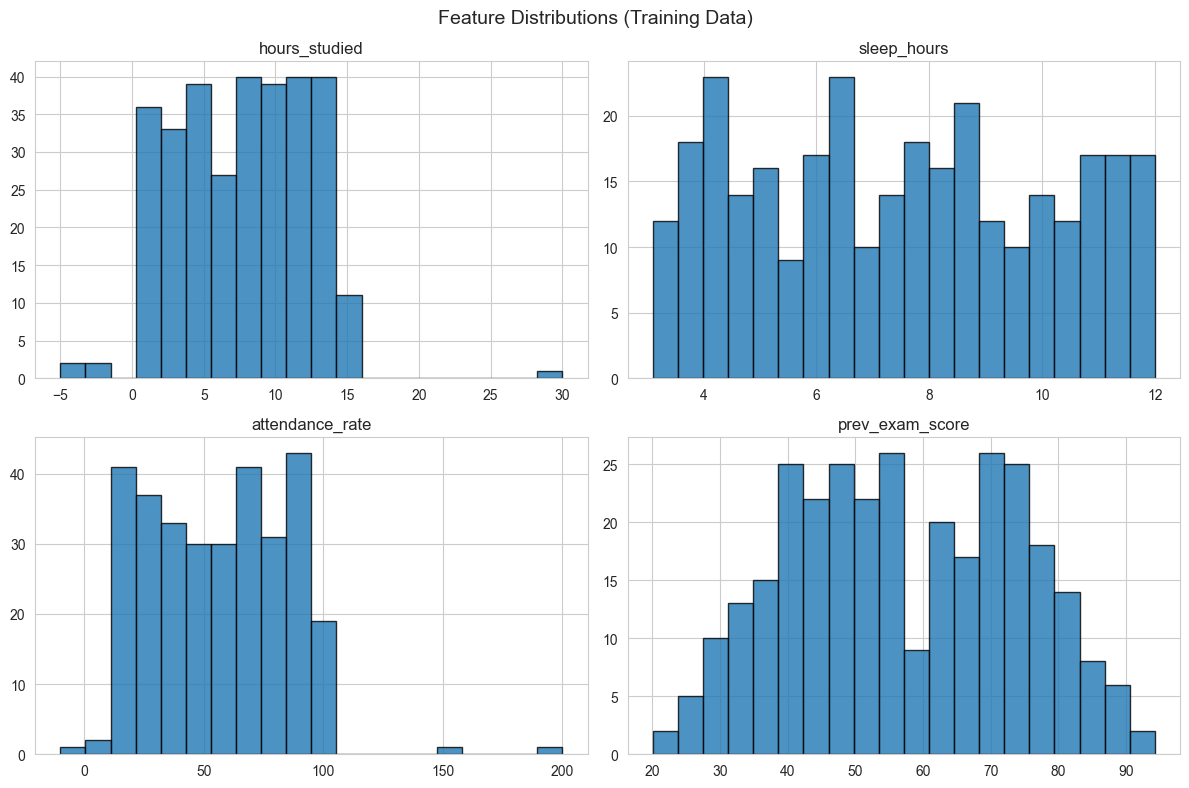

In [4]:
# Visualization 1: Histogram for dataset feature distributions
training_raw[feature_columns].hist(bins=20, figsize=(12, 8), edgecolor="black", alpha=0.8)
plt.suptitle("Feature Distributions (Training Data)", fontsize=14)
plt.tight_layout()
plt.show()

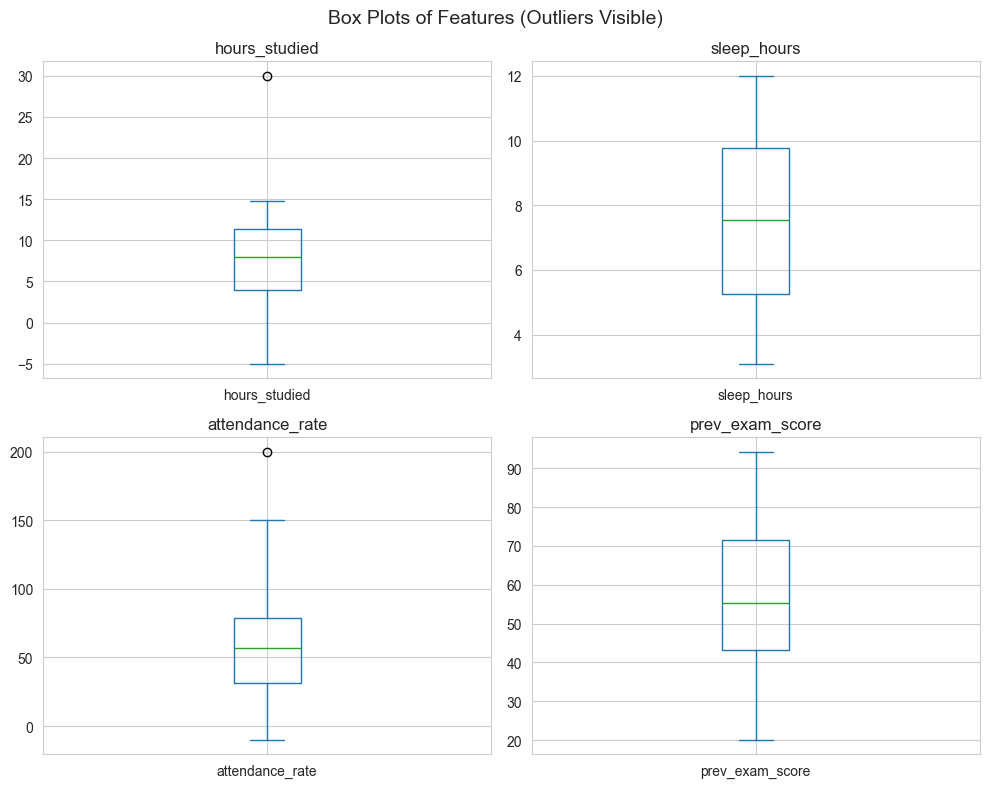

In [5]:
# Visualization 2: Box plots for each feature
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for ax, col in zip(axes.ravel(), feature_columns):
    training_raw[col].dropna().plot(kind="box", ax=ax)
    ax.set_title(col)
plt.suptitle("Box Plots of Features (Outliers Visible)", fontsize=14)
plt.tight_layout()
plt.show()

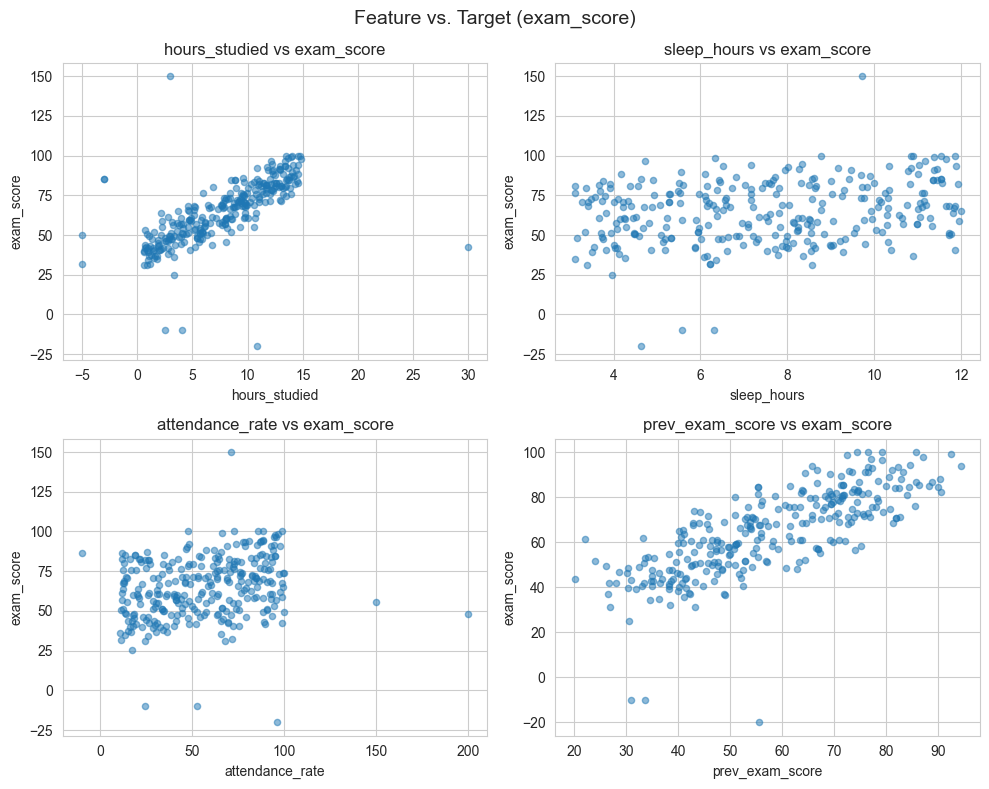

In [6]:
# Visualization 3: Scatter plot for features vs exam_score 
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for ax, col in zip(axes.ravel(), feature_columns):
    ax.scatter(training_raw[col], training_raw["exam_score"], alpha=0.5, s=20)
    ax.set_xlabel(col)
    ax.set_ylabel("exam_score")
    ax.set_title(f"{col} vs exam_score")
plt.suptitle("Feature vs. Target (exam_score)", fontsize=14)
plt.tight_layout()
plt.show()

**Data Quality Issues:**
1. Missing Values:  
The training set is found to have missing values (NaN) for the features we are training the data on.  
‘Hours_studied’, ‘sleep_hours’, ‘attendance_rate’, ‘prev_exam_score’ all have missing values, that will need to be filled in so that training is accurate.  
The target we are training for ‘exam_score’ also has missing values, which will probably need to be deleted from the data, because I cant fill those values in without introducing bias.  
Impact:  
The models cant use NaN as an input value, this would throw off the results and introduce errors.  
So these values either need to be filled in, or the rows will need to be completely removed from the training set.  
Removing these rows is data lass, and that is another form of selection bias, where we are more likely to completely omit data if some of it is partially missing.  
Imputation lets us fill in these missing values, so the models can still train with this data. 

2. Invalid Values / Outliers:  
Each feature has a set range where the values can possibly fall.  
The bounds for each feature depend on what is logically possible.  
‘attendance_rate’, ‘exam_score’, ‘prev_exam_score’ all have bounds from 0 to 100.  
‘hours_studied’ has been capped from 0 to 20, and ‘sleep_hours’ capped from 0 to 15.  
Any values that lie beyond this need to be clipped to either the lower or upper range. 
For example in the hours_studied column, one row has a value of -5.  
This is physically impossible, a student cant sleep -5 hours. So instead this value will be clipped to 0.  
Impact:  
Invalid values are probably from entry errors. These can affect statistics because they dont make sense in reality.  
This is really important for gradient descent, because extreme values can affect convergence and affect the testing set. 

3. Duplicate records:
The training set also has duplicate records.  
The duplicates are either full rows with matching values, or duplicates isolated to the 4 features we’re testing for.  
The second copy of these duplicates should be removed from the data set.  
Impact:  
Duplicates give more weight to those specific rows, which can cause overfitting.  
Repetitions in data and overfitting can lead to false results when I introduce the testing set.  


**Feature Target Relationships**  
Looking at the scatter plots, all the features are shown on the x-axis, and the target exam_scores are on the y axis.  
1. Hours studied vs. exam score:  
There is a positive relationship between the two, with a sharp positive slope.  
As hours studied increases, exam score also increases.
The longer you study, the better the studnet should score on the exam. 

2. Attendance vs exam score:  
There is a positive relationship between the two, with a positive slope.
As a students attendance increases, the exam score increases.  
The more a student attends class and lecture, the more they learn and the better they do on the exam.  

3. Sleep hours vs exam score:  
There is a weak positive relationship between the two features.  
The slope is not as sharply positive, its appears a bit flat, but it still shows slightly positive.  
The relationship is not as strong, but better sleep should help a students performance on a test.   
However extra sleep might not have as large an impact.  

4. Previous exam score vs exam score:  
There is a positive relationship between the two, with a sharp positive slope.  
The relationship is strong like hours studied, as previous exam scores increase, so do the exam scores.  
This makes sense, if a student scored well in a previous exam, you would expect them to also do well on the next one.  


## 1.2 Data Cleaning


In [7]:
# Work on copies: we'll build training_clean and testing_clean
training_clean = training_raw.copy()
testing_clean = testing_raw.copy()
test_clean = testing_clean  
rows_before_cleaning = len(training_clean)
print("Before cleaning - Train rows:", rows_before_cleaning)

Before cleaning - Train rows: 326


In [8]:
# 1) Missing values: impute with training median 

# Before imputation 
missing_before = training_raw[feature_columns].isnull().sum()
print("Missing values BEFORE imputation (train, original data):")
print(missing_before.to_string())
print("  Total:", missing_before.sum())

medians = training_clean[feature_columns].median()
training_clean[feature_columns] = training_clean[feature_columns].fillna(medians)
testing_clean[feature_columns] = testing_clean[feature_columns].fillna(medians)

# After imputation
missing_after = training_clean[feature_columns].isnull().sum()
print("\nMissing values AFTER imputation (train):")
print(missing_after.to_string())
print("  Total:", missing_after.sum())

print("\nJustification: Cleaning missing values preserves sample size. \nWe use the median imputation to fill any missing rows b/c it's \nless sensitive to outliers than using the mean.")

Missing values BEFORE imputation (train, original data):
hours_studied      16
sleep_hours        16
attendance_rate    16
prev_exam_score    16
  Total: 64

Missing values AFTER imputation (train):
hours_studied      0
sleep_hours        0
attendance_rate    0
prev_exam_score    0
  Total: 0

Justification: Cleaning missing values preserves sample size. 
We use the median imputation to fill any missing rows b/c it's 
less sensitive to outliers than using the mean.


In [10]:
# 2) Outliers: clip to valid physical ranges 
valid_ranges = {
    "hours_studied": (0, 20),
    "sleep_hours": (0, 15),
    "attendance_rate": (0, 100),
    "prev_exam_score": (0, 100),
    "exam_score": (0, 100),
}

# Before clipping 
print("Values outside bounds BEFORE clipping (train, original data):")
outliers_before = 0
for col, (lo, hi) in valid_ranges.items():
    if col in training_raw.columns:
        out_of_range = (training_raw[col] < lo) | (training_raw[col] > hi)
        total_invalid = out_of_range.sum()
        outliers_before += total_invalid
        print(f"  {col}: {total_invalid} values outside [{lo}, {hi}]")
print(f"  Total values outside bounds: {outliers_before}")

for col, (lo, hi) in valid_ranges.items():
    if col in training_clean.columns:
        training_clean[col] = training_clean[col].clip(lo, hi)
    if col in testing_clean.columns:
        testing_clean[col] = testing_clean[col].clip(lo, hi)

# After clipping
print("\nValues outside bounds AFTER clipping (train):")
outliers_after = 0
for col, (lo, hi) in valid_ranges.items():
    if col in training_clean.columns:
        out_of_range = (training_clean[col] < lo) | (training_clean[col] > hi)
        total_invalid = out_of_range.sum()
        outliers_after += total_invalid
        print(f"  {col}: {total_invalid} values outside [{lo}, {hi}]")
print(f"  Total values outside bounds: {outliers_after}")

print("\nJustification: We remove outliers by clipping to valid ranges. This removes \nimpossible values like negative hours studied, attendance rates above 100, \nand exam scores above 100 without dropping rows. For example, hours studied has an \noutlier of 30 hours, we clip it to 20 hours.")

Values outside bounds BEFORE clipping (train, original data):
  hours_studied: 5 values outside [0, 20]
  sleep_hours: 0 values outside [0, 15]
  attendance_rate: 3 values outside [0, 100]
  prev_exam_score: 0 values outside [0, 100]
  exam_score: 4 values outside [0, 100]
  Total values outside bounds: 12

Values outside bounds AFTER clipping (train):
  hours_studied: 0 values outside [0, 20]
  sleep_hours: 0 values outside [0, 15]
  attendance_rate: 0 values outside [0, 100]
  prev_exam_score: 0 values outside [0, 100]
  exam_score: 0 values outside [0, 100]
  Total values outside bounds: 0

Justification: We remove outliers by clipping to valid ranges. This removes 
impossible values like negative hours studied, attendance rates above 100, 
and exam scores above 100 without dropping rows. For example, hours studied has an 
outlier of 30 hours, we clip it to 20 hours.


In [11]:
# 3) Duplicate records: drop duplicates based on feature columns (keep first occurrence)
duplicates_before = len(training_clean)
print("BEFORE removing duplicates - Train rows:", duplicates_before)

training_clean = training_clean.drop_duplicates(subset=feature_columns, keep="first")
duplicates_after = len(training_clean)

print("AFTER removing duplicates - Train rows:", duplicates_after, "| Rows removed:", duplicates_before - duplicates_after)
print("\nJustification: Full row duplicates were not found, however duplicates were \nfound for 12 records between the 4 feature columns, meaning we will be deleting 6 \nrows from the training dataset. Duplicates would give those points double weight in \ngradient descent so keeping only one will prevent overfitting.")

BEFORE removing duplicates - Train rows: 326
AFTER removing duplicates - Train rows: 320 | Rows removed: 6

Justification: Full row duplicates were not found, however duplicates were 
found for 12 records between the 4 feature columns, meaning we will be deleting 6 
rows from the training dataset. Duplicates would give those points double weight in 
gradient descent so keeping only one will prevent overfitting.


In [12]:
# For regression/classification we drop rows where target is missing - only for training set
total_rows = len(training_clean)
missing_exam_values = training_clean["exam_score"].isnull().sum()
print("BEFORE dropping rows with missing target values:")
print("  Total training rows:", total_rows)
print("  Total rows missing exam_score:", missing_exam_values)
print("  \nThe raw data had 17 missing exam values. \nHowever one was found in a row flagged with \nduplicated values, so it was removed earlier.")

training_clean = training_clean.dropna(subset=["exam_score", "passed"])  # keep only rows with both targets valid

print("\nAFTER dropping rows with missing target values:")
print("  Total rows dropped:", total_rows - len(training_clean))
print("  Final training size:", len(training_clean))

print("\nJustification: Here I drop the rows that have a missing target value, the exam_score. \nI can't fill in these values myself because I would be introducing bias to the data. \nWe need to use the same dataset for both regression and classification.")


BEFORE dropping rows with missing target values:
  Total training rows: 320
  Total rows missing exam_score: 16
  
The raw data had 17 missing exam values. 
However one was found in a row flagged with 
duplicated values, so it was removed earlier.

AFTER dropping rows with missing target values:
  Total rows dropped: 16
  Final training size: 304

Justification: Here I drop the rows that have a missing target value, the exam_score. 
I can't fill in these values myself because I would be introducing bias to the data. 
We need to use the same dataset for both regression and classification.


## 1.3 Feature Selection


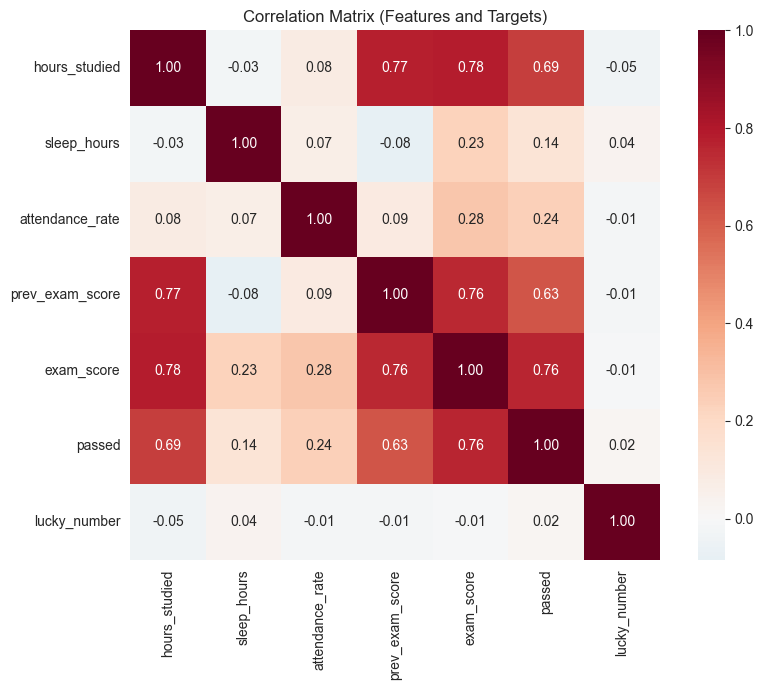

In [13]:
# Correlation matrix - this helps to see which features are most correlated with the target
correlation_columns = feature_columns + ["exam_score", "passed", "lucky_number"]
correlation_dataframe = training_clean[correlation_columns].corr()
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_dataframe, annot=True, fmt=".2f", cmap="RdBu_r", center=0, square=True)
plt.title("Correlation Matrix (Features and Targets)")
plt.tight_layout()
plt.show()

**Feature Analysis:**
Looking at the heatmap scores.  

1. Selected Features:  

‘Hours_studied’ - has a 0.78 correlation to exam score, this means there's a high chance of correlation and impact towards the target.  
Hours studied is an important metric for evaluating a students performance.
  
‘Attendace_rate’ - has a 0.28 correlation to exam score.  
Its not as strong an indicator as hours studied, but it can be important metric for evaluating a studied exposure to the learning material.
  
‘Sleep_hours’ - has a 0.23 correlation to exam score.  
This is also not as strong an indicator, but it affects a students concentration and memory retention, so it could have an impact towards exam scores.
  
‘Prev_exam_score’ - has a 0.76 correlation to exam score.  
This is a strong indicator similar to hours studied.  
If a student has already proven to do well on other exams, you can expect them to do similarly in the future exams. 
  
2. Excluded features:  
  
‘Lucky_number’ - has a -0.01 correlation.  
Lucky number is a completely random metric, and has no impact to how a student would do on a test.  

‘Exam_score’ - this is the target we are setting our model up for.  
So it would not make sense to have this as a feature.  
  
‘Passed’ - this is a classification that is dependent on the exam score value, so it again does not make sense to use this as a feature for the model.  



## 1.4 Data Normalization


In [14]:
# Use training_clean (rows with both targets valid)
X_training_unscaled = training_clean[feature_columns].values
X_testing_unscaled = testing_clean[feature_columns].values
y_training_regression = training_clean["exam_score"].values
y_training_classification = training_clean["passed"].values.astype(np.float64)
y_training_regression = y_training_regression 
y_training_classification = y_training_classification

# Before normalization stats
mean_before = X_training_unscaled.mean(axis=0)
std_before = X_training_unscaled.std(axis=0)
print("Before normalization (train features):")
for i, col in enumerate(feature_columns):
    print(f"  {col}:  mean = {mean_before[i]:.4f},  std = {std_before[i]:.4f}")

Before normalization (train features):
  hours_studied:  mean = 7.7648,  std = 4.1971
  sleep_hours:  mean = 7.4765,  std = 2.5033
  attendance_rate:  mean = 55.4447,  std = 26.7912
  prev_exam_score:  mean = 57.1721,  std = 16.2437


In [15]:
# Z-score normalization: fit on train, apply to train and test
training_mean = X_training_unscaled.mean(axis=0)
training_std = X_training_unscaled.std(axis=0)
training_std = np.where(training_std == 0, 1, training_std)  # avoid division by zero
X_training_standardized = (X_training_unscaled - training_mean) / training_std
X_testing_standardized = (X_testing_unscaled - training_mean) / training_std
X_training_standardized = X_training_standardized 
X_testing_standardized = X_testing_standardized

print("After Z-score normalization: all features normalized to mean = 0.0, std = 1.0")
print("\nFirst 5 rows of Z-score normalized data:")
print(pd.DataFrame(X_training_standardized[:5], columns=feature_columns).to_string(index=True))

After Z-score normalization: all features normalized to mean = 0.0, std = 1.0

First 5 rows of Z-score normalized data:
   hours_studied  sleep_hours  attendance_rate  prev_exam_score
0       0.046504     1.403552        -0.530573         0.592098
1      -0.232263     0.017372         0.204369        -0.107250
2       1.526112     0.976114        -1.119572         1.946470
3       0.677899    -0.905417        -0.894125        -0.171891
4      -0.148871    -0.893433        -0.570512         0.057737


In [16]:
# L2 (vector) normalization: scale each row so its L2 norm = 1 (fit on train, then apply to train and test)
def l2_normalize(X):
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms = np.where(norms == 0, 1, norms)
    return X / norms

X_training_l2_normalized = l2_normalize(X_training_standardized)  # apply L2 to Z-scored features
X_testing_l2_normalized = l2_normalize(X_testing_standardized)
print("After L2 (vector) normalization: each row has L2 norm = 1.0")
print("\nFirst 5 rows of L2-normalized data:")
print(pd.DataFrame(X_training_l2_normalized[:5], columns=feature_columns).to_string(index=True))

After L2 (vector) normalization: each row has L2 norm = 1.0

First 5 rows of L2-normalized data:
   hours_studied  sleep_hours  attendance_rate  prev_exam_score
0       0.028817     0.869742        -0.328781         0.366907
1      -0.708338     0.052980         0.623270        -0.327084
2       0.528957     0.338325        -0.388048         0.674655
3       0.466869    -0.623561        -0.615784        -0.118381
4      -0.138871    -0.833420        -0.532190         0.053859


**Why Normalization is important**
  
Normalization is important because the 4 features have different scales and values, for example hour_studied is on a scale of 0 to 20, sleep_hours is 0 to 15, attendance_rate and prev_exam_score are 0 to 100.  
This makes these values unbalanced when working with gradient descent.  
Normalization with z-score limits all value bounds from -1 to 1.  
This is important because any extreme small and large values are bounded, so the extreme values dont dominate the training set results.  
If we have a bunch of attendance values at 100, and then sleep hours values from 0 to 15, the attendance values magnitude is significantly larger, and would skew the results.  
Normalizing the data with Z-score makes the values balanced, and has faster convergence.  
L2 vector normalization makes each sample a unit vector, meaning the direction of the vector matters more than its magnitude.


---
# 2. Linear Regression

## 2.1 NumPy Implementation


In [17]:
# Design matrix with intercept (fit on Z-scored features)
assert X_training_standardized.shape[0] == len(y_training_regression), (
    "X and y row count mismatch. Re-run Section 1 in order: drop missing targets, then build X,y, then Z-score."
)
assert np.all(np.isfinite(y_training_regression)), (
    "y_training_regression has NaNs. Re-run the 'drop missing targets' cell, then build X,y and Z-score. "
)
def add_intercept(X):
    return np.column_stack([np.ones(len(X)), X])

X_training_regression = add_intercept(X_training_standardized)
X_testing_regression = add_intercept(X_testing_standardized)
num_samples, num_weights_regression = X_training_regression.shape
print("Design matrix shape (train):", X_training_regression.shape)

Design matrix shape (train): (304, 5)


In [18]:
# NumPy: MSE cost and gradient for linear regression
# prediction = X @ w  =>  MSE = (1/n) * sum((y - Xw)^2)
# Gradient: dMSE/dw = (2/n) * X^T @ (Xw - y)

def mse_cost(X, y, w):
    n = len(y)
    prediction = X @ w #matrix multiplication of X and w
    return np.mean((y - prediction) ** 2) # mean of the squared differences between the predicted and actual values

def mse_gradient(X, y, w):
    n = len(y)
    prediction= X @ w
    return (2 / n) * (X.T @ (prediction - y))

# Gradient descent 
np.random.seed(42)
weights_regression = np.zeros(num_weights_regression)
learning_rate = 0.01
num_iterations = 2000
loss_regression = []
for i in range(num_iterations):
    loss = mse_cost(X_training_regression, y_training_regression, weights_regression)
    loss_regression.append(loss)
    gradient = mse_gradient(X_training_regression, y_training_regression, weights_regression)
    weights_regression= weights_regression - learning_rate * gradient

print("Final parameters (NumPy):", weights_regression)
print("Final training MSE (NumPy):", mse_cost(X_training_regression, y_training_regression, weights_regression))
print("Final testing MSE (NumPy):", mse_cost(X_testing_regression, test_clean["exam_score"].values, weights_regression))

Final parameters (NumPy): [64.74118421  8.40692276  4.8642345   3.33987262  7.51903784]
Final training MSE (NumPy): 73.8328353604079
Final testing MSE (NumPy): 35.2913774937885


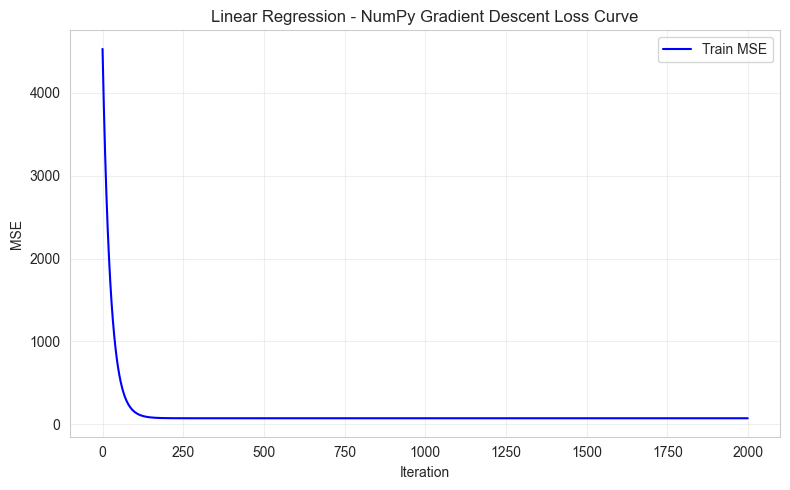

In [19]:
# Loss curve (MSE vs iteration)
plt.plot(loss_regression, color="blue", label="Train MSE")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.title("Linear Regression - NumPy Gradient Descent Loss Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2.2 PyTorch Verification


In [20]:
# PyTorch linear regression 
X_tensor_regression = torch.tensor(X_training_regression, dtype=torch.float32)
y_tensor_regression = torch.tensor(y_training_regression, dtype=torch.float32).reshape(-1, 1)
linear_model = nn.Linear(num_weights_regression, 1, bias=False)  # num_weights_regression = 5 (intercept + 4 features)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.01)
loss_regression_torch = []
for i in range(num_iterations):
    optimizer.zero_grad()
    pred = linear_model(X_tensor_regression)
    loss = criterion(pred, y_tensor_regression)
    loss_regression_torch.append(loss.item())
    loss.backward()
    optimizer.step()

weights_regression_torch = linear_model.weight.squeeze().detach().numpy()
train_mse_torch = criterion(linear_model(X_tensor_regression), y_tensor_regression).item()
X_test_tensor_regression = torch.tensor(X_testing_regression, dtype=torch.float32)
y_test_tensor_regression = torch.tensor(test_clean["exam_score"].values, dtype=torch.float32).reshape(-1, 1)
test_mse_torch = criterion(linear_model(X_test_tensor_regression), y_test_tensor_regression).item()

print("Final parameters (PyTorch):", weights_regression_torch)
print("Final training MSE (PyTorch):", train_mse_torch)
print("Final test MSE (PyTorch):", test_mse_torch)

Final parameters (PyTorch): [64.741      8.406863   4.864249   3.3398654  7.5190945]
Final training MSE (PyTorch): 73.83284759521484
Final test MSE (PyTorch): 35.29179763793945


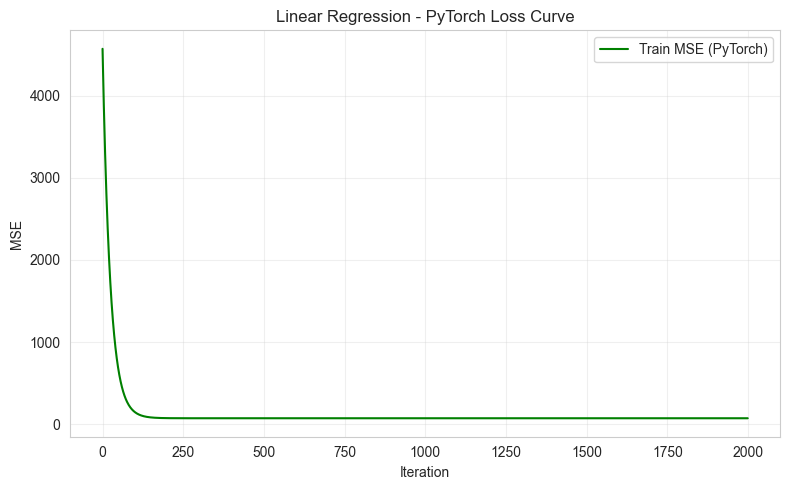

In [21]:
# Loss curve PyTorch
plt.plot(loss_regression_torch, color="green", label="Train MSE (PyTorch)")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.title("Linear Regression - PyTorch Loss Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [22]:
# Side-by-side comparison: NumPy vs PyTorch 
comparison = pd.DataFrame({
    "Parameter": ["intercept"] + feature_columns,
    "NumPy": weights_regression,
    "PyTorch": weights_regression_torch,
})
comparison["Diff"] = np.abs(comparison["NumPy"] - comparison["PyTorch"])
print(comparison.to_string(index=False))
print("\nMSE comparison:")
print(f"  Training MSE - NumPy:   {mse_cost(X_training_regression, y_training_regression, weights_regression):.6f}  |  PyTorch: {train_mse_torch:.6f}")
print(f"  Testing MSE  - NumPy:  {mse_cost(X_testing_regression, testing_clean['exam_score'].values, weights_regression):.6f}  |  PyTorch: {test_mse_torch:.6f}")


      Parameter     NumPy   PyTorch     Diff
      intercept 64.741184 64.740997 0.000187
  hours_studied  8.406923  8.406863 0.000060
    sleep_hours  4.864235  4.864249 0.000015
attendance_rate  3.339873  3.339865 0.000007
prev_exam_score  7.519038  7.519094 0.000057

MSE comparison:
  Training MSE - NumPy:   73.832835  |  PyTorch: 73.832848
  Testing MSE  - NumPy:  35.291377  |  PyTorch: 35.291798


**Discussion:**  
There are few small differecnes between the numpy and pytorch implementation, but the results are very similar. 
This proves that the numpy implementation was done correctly.  
  
The intercept is 64.74. This is the constant in the equation when all the features are 0.  
ŷ = 64.74 + bx  
  
Each feature has a value in the equation that represents how much the exam score would be impacted depending on the change to that feature, with all other features unchanged.  
For example: hour_studied the equation is ŷ = 64.74 + 8.41x  
This means if the student goes from 5 hour to 6 hours studied, you could expect an increase in their exam score of 8.41 poitns.  
  
For sleep_hours the equation is ŷ = 64.74 + 4.86x.  
For attendance_rate the equation is ŷ = 64.74 + 3.34x.  
For prev_exam_score the equation is ŷ = 64.74 + 7.52x.  
  
Training MSE is 73.83, this is the mean squared error on the data used to fit the model. The square root of the MSE is the RMSE, which is 8.6, which means the predictions are off by 8.6 points on average.  

Testing MSE is 35.29. Having a lower test MSE than the train MSE is a good sign, it means the model is not overfitting and is generalizing to the test set well.


## 2.3 Polynomial Regression
Train polynomial models (degree = 2, 3, 5, 10)


In [23]:
# Polynomial feature expansion 
from sklearn.preprocessing import PolynomialFeatures

def fit_linear_closed_form(X, y):
    """Closed-form solution for comparison: w = (X'X)^{-1} X'y"""
    return np.linalg.lstsq(X, y, rcond=None)[0]

degrees = [2, 3, 5, 10]
polynomial_results = []
polynomial_models = {}  # store weights per degree for plotting

for d in degrees:
    polynomial = PolynomialFeatures(degree=d, include_bias=True)
    X_training_polynomial = polynomial.fit_transform(X_training_standardized)  # fit on training set
    X_testing_polynomial = polynomial.transform(X_testing_standardized)        # transform testing set with same polynomial
    w = fit_linear_closed_form(X_training_polynomial, y_training_regression)
    polynomial_models[d] = (polynomial, w)
    training_mse = mse_cost(X_training_polynomial, y_training_regression, w)
    testing_mse = mse_cost(X_testing_polynomial, testing_clean["exam_score"].values, w)
    polynomial_results.append({"degree": d, "training_mse": training_mse, "testing_mse": testing_mse})

df_poly = pd.DataFrame(polynomial_results)
print("Training and Testing MSE per polynomial degree:")
print(df_poly.to_string(index=False))

Training and Testing MSE per polynomial degree:
 degree  training_mse  testing_mse
      2  6.926546e+01 3.511621e+01
      3  5.529244e+01 4.224759e+01
      5  3.388097e+01 6.394196e+02
     10  1.390201e-20 4.211294e+06


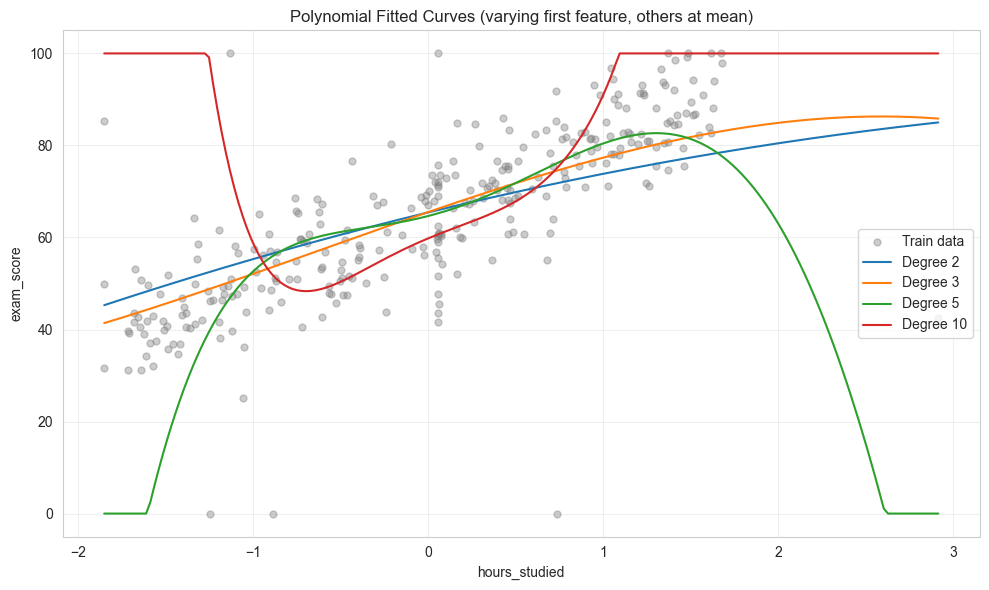

In [25]:
# Overlay plot: show fitted curve for one feature- hours_studied vs exam_score
# Fix other features at their mean
feature_index = 0  # hours_studied
x_min, x_max = X_training_standardized[:, feature_index].min(), X_training_standardized[:, feature_index].max()
x_plot = np.linspace(x_min, x_max, 200)
# Base row: all features at mean (0 after z-score)
base = np.zeros((len(x_plot), X_training_standardized.shape[1]))
base[:, feature_index] = x_plot

plt.figure(figsize=(10, 6))
plt.scatter(X_training_standardized[:, feature_index], y_training_regression, alpha=0.4, s=25, label="Train data", c="gray")

for d in degrees:
    polynomial, w = polynomial_models[d]
    X_curve = polynomial.transform(base)
    y_plot = X_curve @ w
    y_plot = np.clip(y_plot, 0, 100)
    plt.plot(x_plot, y_plot, label=f"Degree {d}")

plt.xlabel(feature_columns[feature_index])
plt.ylabel("exam_score")
plt.title("Polynomial Fitted Curves (varying first feature, others at mean)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Overfitting and Underfitting**  

It trained on 4 different degrees: 2, 3, 5, 10.  
The lower degrees 2 and 3 are shown to fit the curves better than the higher degrees 5 and 10.  
  
Degree 2 - the model fits the training set with MSE of 6.92, and the testing error is at its lowest at 3.51. This would be the best degree model to use because it has the lowest testing error.  
  
Degree 3 - this model fits the training set better with MSE of 5.53, and the testing error is a little higher at 4.22. 
   
Degree 5 - the training error drops even lower at MSE of 3.38, but the testing error just higher to 6.39. This is a sign of overfitting. The model is fit better on training but not accurate for testing.  
  
Degree 10 - the training error is the lowest at MSE of 1.39, and the testing error is 4.21, still higher than training, and suggests overfitting on training data again.  
  

Degree 2 is the best performance for the model because it has the lowest testing error.  
Meaning it fits well on new unseen data that it hasn't been trained on.  


---
# 3. Logistic Regression

## 3.1 NumPy Implementation


In [31]:
# Design matrix for classification
X_training_classification = add_intercept(X_training_standardized)
X_testing_classification = add_intercept(X_testing_standardized)
num_weights_classification = X_training_classification.shape[1]

# Sigmoid and cross-entropy (binary): - (1/n) * sum( y*log(p) + (1-y)*log(1-p) ), p = sigmoid(X@w)
def sigmoid(linear_score):
    linear_score = np.clip(linear_score, -500, 500)
    return 1.0 / (1.0 + np.exp(-linear_score))

def cross_entropy_cost(X, y, w):
    n = len(y)
    predicted_prob = sigmoid(X @ w)
    predicted_prob = np.clip(predicted_prob, 1e-15, 1 - 1e-15)
    return -np.mean(y * np.log(predicted_prob) + (1 - y) * np.log(1 - predicted_prob))

# Gradient: d/dw = (1/n) * X^T @ (p - y)
def ce_gradient(X, y, w):
    n = len(y)
    predicted_prob = sigmoid(X @ w)
    return (X.T @ (predicted_prob - y)) / n

# Gradient descent for logistic regression
np.random.seed(42)
weights_classification = np.zeros(num_weights_classification)
learning_rate_classification = 0.1
num_iterations_classification = 3000
loss_classification = []
for i in range(num_iterations_classification):
    loss = cross_entropy_cost(X_training_classification, y_training_classification, weights_classification)
    loss_classification.append(loss)
    gradient = ce_gradient(X_training_classification, y_training_classification, weights_classification)
    weights_classification = weights_classification - learning_rate_classification * gradient

# Predict with threshold 0.5
def predict_class(X, w, thresh=0.5):
    return (sigmoid(X @ w) >= thresh).astype(int)

training_accuracy = np.mean(predict_class(X_training_classification, weights_classification) == y_training_classification)
y_testing_classification = testing_clean["passed"].values
testing_accuracy = np.mean(predict_class(X_testing_classification, weights_classification) == y_testing_classification)
print("Final parameters (NumPy logistic):", weights_classification)
print("Training accuracy (NumPy, threshold=0.5):", training_accuracy)
print("Testing accuracy (NumPy, threshold=0.5):", testing_accuracy)

Final parameters (NumPy logistic): [0.95651515 1.97408036 0.90534595 0.84213612 1.25750345]
Training accuracy (NumPy, threshold=0.5): 0.8453947368421053
Testing accuracy (NumPy, threshold=0.5): 0.875


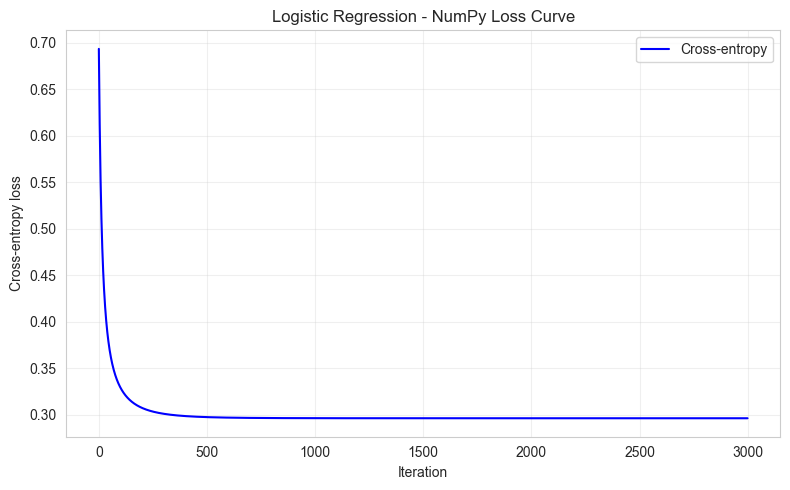

In [32]:
# Loss curve (cross-entropy vs iteration)
plt.plot(loss_classification, color="blue", label="Cross-entropy")
plt.xlabel("Iteration")
plt.ylabel("Cross-entropy loss")
plt.title("Logistic Regression - NumPy Loss Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3.2 PyTorch Verification


In [33]:
# PyTorch logistic regression (bias=False since we have intercept in X)
X_tensor_classification = torch.tensor(X_training_classification, dtype=torch.float32)
y_tensor_classification = torch.tensor(y_training_classification, dtype=torch.float32).reshape(-1, 1)
model_log = nn.Linear(num_weights_classification, 1, bias=False)
criterion_log = nn.BCEWithLogitsLoss()  # applies sigmoid internally
optimizer_log = torch.optim.SGD(model_log.parameters(), lr=0.1)
loss_classification_torch = []
for i in range(num_iterations_classification):
    optimizer_log.zero_grad()
    logits = model_log(X_tensor_classification)
    loss = criterion_log(logits, y_tensor_classification)
    loss_classification_torch.append(loss.item())
    loss.backward()
    optimizer_log.step()

weights_classification_torch = model_log.weight.squeeze().detach().numpy()
# Accuracy with threshold 0.5 (logits -> sigmoid -> compare to 0.5)
with torch.no_grad():
    probs = torch.sigmoid(model_log(X_tensor_classification))
    train_acc_t = (probs.numpy().ravel() >= 0.5).astype(int)
    train_accuracy_torch = np.mean(train_acc_t == y_training_classification)
    X_test_tensor_classification = torch.tensor(X_testing_classification, dtype=torch.float32)
    probs_test = torch.sigmoid(model_log(X_test_tensor_classification))
    test_pred_t = (probs_test.numpy().ravel() >= 0.5).astype(int)
    test_accuracy_torch = np.mean(test_pred_t == y_testing_classification)

print("Final parameters (PyTorch):", weights_classification_torch)
print("Train accuracy (PyTorch):", train_accuracy_torch)
print("Test accuracy (PyTorch):", test_accuracy_torch)

Final parameters (PyTorch): [0.9565057  1.97395    0.9053344  0.84212255 1.2576025 ]
Train accuracy (PyTorch): 0.8453947368421053
Test accuracy (PyTorch): 0.875


In [34]:
# Side-by-side comparison: NumPy vs PyTorch 
comparison_log = pd.DataFrame({
    "Parameter": ["intercept"] + feature_columns,
    "NumPy": weights_classification,
    "PyTorch": weights_classification_torch,
})
comparison_log["Diff"] = np.abs(comparison_log["NumPy"] - comparison_log["PyTorch"])
print(comparison_log.to_string(index=False))
print("\nAccuracy comparison:")
print(f"  Train accuracy - NumPy:   {training_accuracy:.4f}  |  PyTorch: {train_accuracy_torch:.4f}")
print(f"  Test accuracy  - NumPy:  {testing_accuracy:.4f}  |  PyTorch: {test_accuracy_torch:.4f}")


      Parameter    NumPy  PyTorch     Diff
      intercept 0.956515 0.956506 0.000009
  hours_studied 1.974080 1.973950 0.000130
    sleep_hours 0.905346 0.905334 0.000012
attendance_rate 0.842136 0.842123 0.000014
prev_exam_score 1.257503 1.257602 0.000099

Accuracy comparison:
  Train accuracy - NumPy:   0.8454  |  PyTorch: 0.8454
  Test accuracy  - NumPy:  0.8750  |  PyTorch: 0.8750


## 3.3 Analysis & Visualization


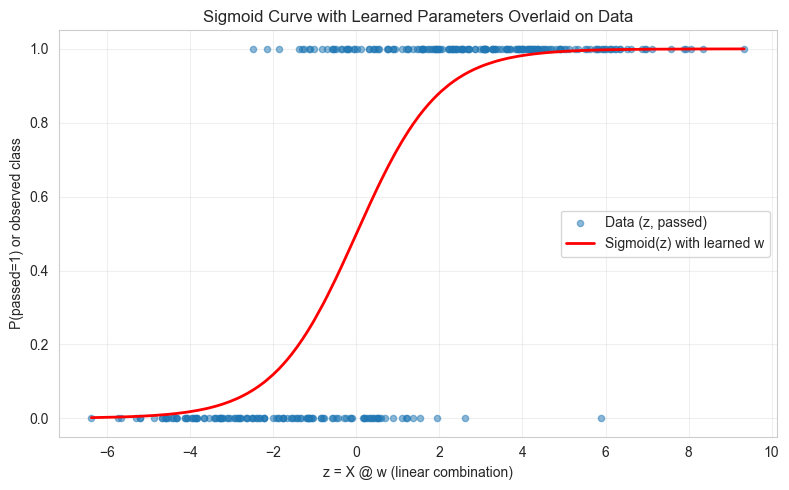

In [35]:
# Sigmoid curve: use linear combination z = X @ w (1D) vs P(passed=1) = sigmoid(z)
z_train = X_training_classification @ weights_classification
z_sorted = np.sort(z_train)
p_sorted = sigmoid(z_sorted)
plt.figure(figsize=(8, 5))
plt.scatter(z_train, y_training_classification, alpha=0.5, s=20, label="Data (z, passed)")
plt.plot(z_sorted, p_sorted, color="red", linewidth=2, label="Sigmoid(z) with learned w")
plt.xlabel("z = X @ w (linear combination)")
plt.ylabel("P(passed=1) or observed class")
plt.title("Sigmoid Curve with Learned Parameters Overlaid on Data")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

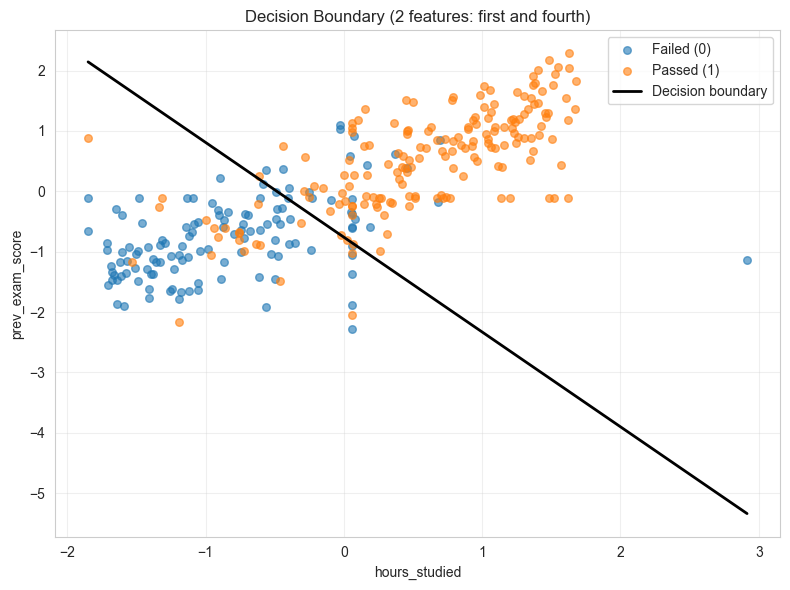

In [36]:
# Decision boundary with 2 features: hours_studied, prev_exam_score
i1, i2 = 0, 3 
f1_vals = X_training_standardized[:, i1]
f2_vals = X_training_standardized[:, i2]
plt.figure(figsize=(8, 6))
plt.scatter(f1_vals[y_training_classification == 0], f2_vals[y_training_classification == 0], alpha=0.6, label="Failed (0)", s=30)
plt.scatter(f1_vals[y_training_classification == 1], f2_vals[y_training_classification == 1], alpha=0.6, label="Passed (1)", s=30)
# Decision boundary: w0 + w1*x1 + w[i2+1]*x2 = 0  =>  x2 = -(w0 + w1*x1) / w[i2+1]
w0, w1, w2 = weights_classification[0], weights_classification[1], weights_classification[i2 + 1]
x1_line = np.linspace(f1_vals.min(), f1_vals.max(), 100)
x2_line = -(w0 + w1 * x1_line) / w2 if w2 != 0 else np.zeros_like(x1_line)
plt.plot(x1_line, x2_line, "k-", linewidth=2, label="Decision boundary")
plt.xlabel(feature_columns[i1])
plt.ylabel(feature_columns[i2])
plt.title("Decision Boundary (2 features: first and fourth)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Accuracy at different thresholds:
 threshold  train_acc  test_acc
       0.3   0.855263    0.8250
       0.5   0.845395    0.8750
       0.7   0.855263    0.8625


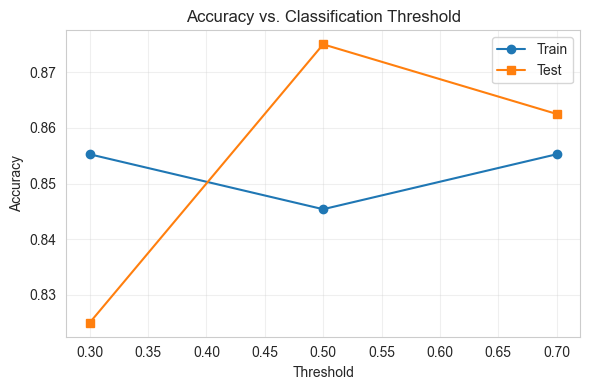

In [37]:
# Accuracy at different thresholds (0.3, 0.5, 0.7)
thresholds = [0.3, 0.5, 0.7]
p_train = sigmoid(X_training_classification @ weights_classification)
p_test = sigmoid(X_testing_classification @ weights_classification)
acc_results = []
for th in thresholds:
    train_a = np.mean((p_train >= th).astype(int) == y_training_classification)
    test_a = np.mean((p_test >= th).astype(int) == y_testing_classification)
    acc_results.append({"threshold": th, "train_acc": train_a, "test_acc": test_a})
df_thresh = pd.DataFrame(acc_results)
print("Accuracy at different thresholds:")
print(df_thresh.to_string(index=False))
plt.figure(figsize=(6, 4))
plt.plot(df_thresh["threshold"], df_thresh["train_acc"], "o-", label="Train")
plt.plot(df_thresh["threshold"], df_thresh["test_acc"], "s-", label="Test")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Classification Threshold")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Thresholds**  
Lowering the threshold to 0.3, means more examples are predicted as positive. Higher threshold  means less examples as predicted as positive.

For a threshold on 0.5, this means that probabilties below 0.5 are labeled as 0 (FAIL) and those above 0.5 are labels as 1 (PASS).   
It would make sense to have the threshold set to the boundary of a passing exam score. 0.5 is 50%, an F which is failing.  
Taking FIU as an example, an F score is consider between 0 and 66.  
So maybe instead we could has the threshold set to 0.66.  

Looking at the university GPA system, a passing gpa at FIU is a C.  
A C is 77–80%, and C- is 75–76%.  
So if we wanted to be accurate to the FIU gpa system for a passing course, the threshold for passing an exam would be at 0.77.  
This means all scores below 77 are classified as 0 (FAIL) and above 77 are classified as 1 (PASS).  
This threshold is obviously very high when looking an individual exam score, and most teachers would still consider an exam of 70 as still passing.  
So its highly dependent on what scale youre using to classify a failing and passing score.

**MSE vs Cross Entropy**  
  
  
MSE from Part 2 is Mean Squared Error, it tells us how far the error is from the predicted values and target values.  
The goal is to predict a value that is as close as possible to the target value.  
Cross entropy is the predicted probability for the positive classification 1 which is passing.  
It measure how well the predicted probability matches up to the classification labels, either 0 (fail) or 1 (passing).  
Cross entropy is better for classification because it outputs a probability, and the cross entropy tries to measure how wrong that prediction is to its matching label.  
MSE is used for actual value targets, not for label predictions. 

___
# 4. Summary and Reflection

### 1. What preprocessing steps had the biggest impact on model performance?

There are a few preprocessing steps I used for data cleaning before working on the models.  
Before any data cleaning there are 326 rows of data.  
First I identify any missing values in the data, it was found that there were 16 values missing for the hour_studied column, 16 missing values for the sleep_hours column, 16 missing values for the attendance_rate, and 16 missing values for prev_exam_score, which is a total of 64 missing values in the training dataset.  
I filled these missing values using the median of their respective columns, using mean would be too sensitive for any outliers found in those columns, so median values avoid that.

Next outliers were identified, I set valid ranges for each feature.  
Hours studied has a range of 0 to 20, sleep hours has a range of 0 to 15, attendance rate, previous exam score, and exam score all have a range of 0 to 100.  
Any values outside of these set ranges are clipped to fit this range.  
There were 12 total outliers found in the dataset, 5 for hours_studied, 3 for attendance_rate, and 4 for exam_score.  
For example one outlier can be found for attendance rate at 200, this is impossible, so it is clipped to 100. 

Next duplicate records were searched specifically between the 4 features the project is training on.  
There were 12 total rows found that were flagged as duplicates.  
This means that 6 rows were removed from the dataset because a duplicate for each was identified, so we keep the first row and remove the second.  
Now we have 320 rows in the data. 

Last, we check the target value for our training, which is exam_score.  
It was found that 17 records are missing an exam_score.  
This means that we have data for the features, but there is no end target result for the model to make a conclusion with.  
This value can't be filled in, because it would introduce bias to the set and it would not be accurate.  
We can't use median, or mean because that would also be false data. So these rows need to be removed.  
One row was already removed earlier because it was flagged as a duplicate row, so we remove 16 rows from the data. 

Before data cleaning we started with 326 rows, and after data cleaning, we ended up with 304 rows to train the model. 

After data cleaning, we move on to data normalization.  
The most impactful effect on the data is this step, because we are normalizing the values of the data into a scale where we can work on them for gradient descent.  
All 4 features have different scales and values, for example hour_studied is on a scale of 0-20, sleep_hours is 0-15, attendance_rate and prev_exam_score are 0-100.  
This makes these values unbalanced when working with gradient descent. Normalizing the data with Z-score makes the values balanced, and has faster convergence.  
L2 vector normalization makes each sample a unit vector, meaning the direction of the vector matters more than its magnitude. 

```
Before Z-score normalization:
  hours_studied:  mean = 7.7648,  std = 4.1971
  sleep_hours:  mean = 7.4765,  std = 2.5033
  attendance_rate:  mean = 55.4447,  std = 26.7912
  prev_exam_score:  mean = 57.1721,  std = 16.2437

After Z-score normalization all the features are normalized to mean = 0.0 and std = 1.0.
First 5 rows of normalized data:
   hours_studied  sleep_hours  attendance_rate  prev_exam_score
0       0.046504     1.403552        -0.530573         0.592098
1      -0.232263     0.017372         0.204369        -0.107250
2       1.526112     0.976114        -1.119572         1.946470
3       0.677899    -0.905417        -0.894125        -0.171891
4      -0.148871    -0.893433        -0.570512         0.057737
```


### 2. How did your NumPy and PyTorch implementations compare? What did implementing from scratch teach you that using a library alone would not?

Both of them implement the same model and formulas.  
Numpy, I write the formula implementation by hand for loss, and gradient results.  
This teaches you the step by step to create the formula and how the data is being passed through. 

Pytroch has built in methods and formulas, I used nn.Linear, nn.MSELoss, and the built in optimizer to get the results.  
Pytorch lets you compute the gradients automatically by using .backward().  
The formulas are the same, but the implementations of these formulas are different. 

```
Numpy implementation results:
Final parameters: [64.74118421  8.40692276  4.8642345  3.33987262  7.51903784]
Final training MSE: 73.8328353604079
Final test MSE: 35.2913774937885

Pytorch implementation results:
Final parameters: [64.741   8.406871   4.8642488   3.3398662   7.519085 ]
Final training MSE: 73.83283233642578
Final test MSE: 35.29176712036133
```
```
Parameter         NumPy      PyTorch    Diff     
intercept         64.741184  64.740997  0.000187 
hours_studied     8.406923   8.406871   0.000052 
sleep_hours       4.864235   4.864249   0.000014 
attendance_rate   3.339873   3.339866   0.000006 
prev_exam_score   7.519038   7.519085   0.000047 
```

```
MSE comparison:
  Training set MSE - NumPy:   73.832835    PyTorch: 73.832832
  Testing set MSE  - NumPy:   35.291377     PyTorch: 35.291767
```

### 3. What was the most challenging part of this project, and how did you resolve it?

The most challenging part was understanding how the Numpy implementation works for Linear, Polynomial, and Logistic Regression.  
It requires a lot of steps and variables and you need to make sure everything is in the right order and format for the algorithm to work. 

For example for linear regression, we need to know how gradient descent works, we need to compute the loss, the gradient, and update the weights, in a loop.  
The number of iterations is important and the learning rate also has to be adjusted.  
The formulas need to be verified through the code, and you need to verify that the numbers actually match and the code runs correctly. 

I also ran into some issues setting up the Kernel and the virtual environment.  
I was getting a 'No module name 'numpy'" error and realized it was because I was running the wrong Kernel. 

### 4. If you had more time, what would you try to improve your models?

If I had more time I would implement a validation set, to help tune the hyperparameters, to get even more reliable results.  
This would reduce any overfitting from the training set.  
I would try different learning rates and iterations. Using a validation set would improve the results we get using the testing set.  

I would also like to try different interactions between features.  
For example finding the relationship between the number of hours and a students attendance. 


